## Generative Adversarial Networks (GAN)

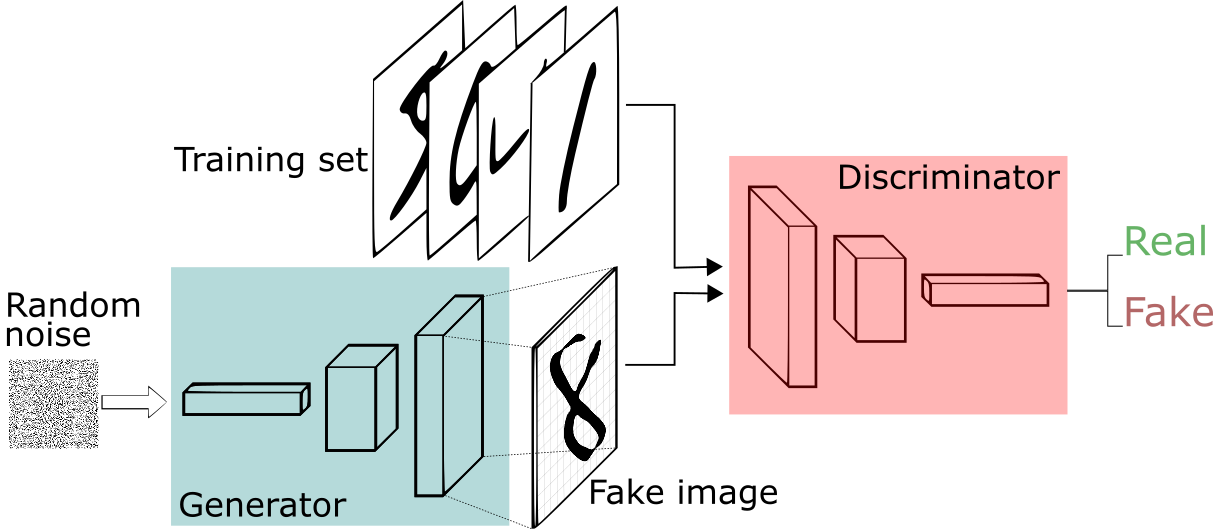

* randomness
* pooling -> strides
* ReLU -> leakyReLU

In [1]:
# MNIST
import numpy as np
from tensorflow import keras
from keras import models 
from keras import layers
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [5]:
# generator: g(noise) -> fake image
latent_dim = 100
length = 28
channels = 1

generator_input = layers.Input(shape=(latent_dim, )) 

x = layers.Dense(128 * 7 * 7)(generator_input)
x = layers.Reshape((7,7,128))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='selu')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(channels, kernel_size=5, strides=2, activation='tanh', padding='same')(x)

generator = models.Model(generator_input, x)
generator.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)       

In [6]:
discriminator_input = layers.Input(shape=(length, length, channels))

x = layers.Conv2D(64, kernel_size=5, strides=2, padding='same')(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128,  kernel_size=5, strides=2, padding='same')(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
 
x = layers.Flatten()(x)
x = layers.Dense(1, activation='sigmoid')(x) # 분류

discriminator = models.Model(discriminator_input, x)
discriminator.summary()

discriminator.compile(loss='binary_crossentropy', optimizer='nadam')

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)        

In [7]:
gin = layers.Input(shape=(latent_dim,))
gout = discriminator(generator(gin))

gan = models.Model(gin, gout) 

discriminator.trainable = False # discriminator는 훈련하지 않음
gan.compile(loss='binary_crossentropy', optimizer='nadam')
gan.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
functional_7 (Functional)    (None, 28, 28, 1)         840705    
_________________________________________________________________
functional_9 (Functional)    (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


#### GAN training
1. random noise
2. generator(noise)
3. real images / fake images
4. discriminator

In [8]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_train = X_train/255
X_train = X_train*2 -1

In [9]:
batch_size = 64
epochs = 1001

def gan_train(epochs, batch_size):    
    true = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    for i in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        img = X_train[idx]
        loss_real = discriminator.train_on_batch(img, true)
 
        # fake 이미지
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen = generator.predict(noise)
        loss_fake = discriminator.train_on_batch(gen, fake)
 
        # 오차 계산
        d_loss = 0.5 * np.add(loss_real, loss_fake)
        g_loss = gan.train_on_batch(noise, true)

        
        if i % 100 == 0:
            noise = np.random.normal(0,1,(batch_size,latent_dim))
            im=generator.predict(noise)
            plt.figure()
            
            plt.subplot(141)
            plt.imshow(im[0, :, :, 0])
            
            plt.subplot(142)
            plt.imshow(im[1, :, :, 0])

            plt.subplot(143)
            plt.imshow(im[2, :, :, 0])

            plt.subplot(144)
            plt.imshow(im[3, :, :, 0])

            plt.show()
            print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

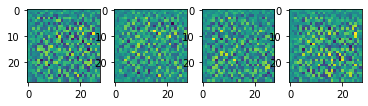

epoch:0  d_loss:0.7081  g_loss:0.6498


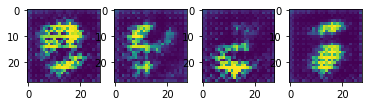

epoch:100  d_loss:0.3177  g_loss:1.7381


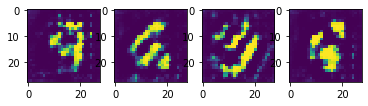

epoch:200  d_loss:0.4872  g_loss:2.5081


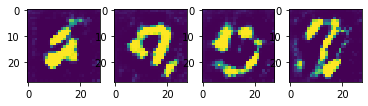

epoch:300  d_loss:0.6117  g_loss:1.7324


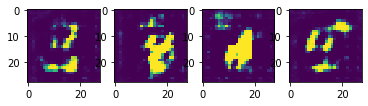

epoch:400  d_loss:0.6493  g_loss:1.6771


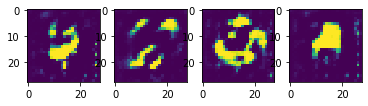

epoch:500  d_loss:0.6210  g_loss:1.6049


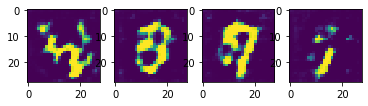

epoch:600  d_loss:0.4958  g_loss:1.9101


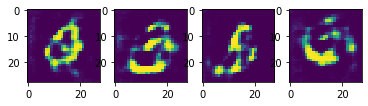

epoch:700  d_loss:0.5000  g_loss:1.9122


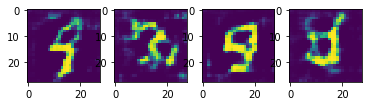

epoch:800  d_loss:0.5827  g_loss:2.0102


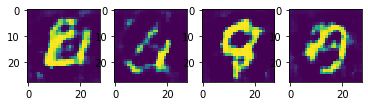

epoch:900  d_loss:0.6460  g_loss:1.4252


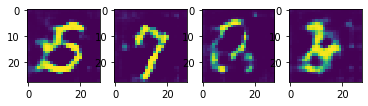

epoch:1000  d_loss:0.7467  g_loss:1.2050


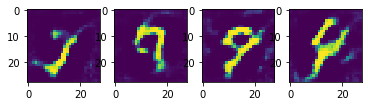

epoch:1100  d_loss:0.6742  g_loss:1.3251


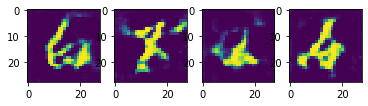

epoch:1200  d_loss:0.7005  g_loss:1.3083


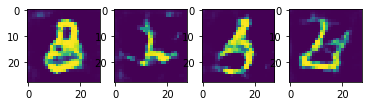

epoch:1300  d_loss:0.6869  g_loss:1.2149


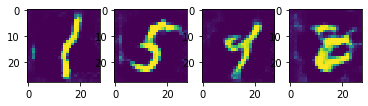

epoch:1400  d_loss:0.5933  g_loss:1.2418


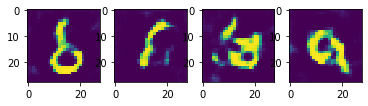

epoch:1500  d_loss:0.6136  g_loss:1.0478


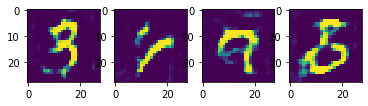

epoch:1600  d_loss:0.7016  g_loss:1.1489


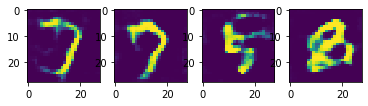

epoch:1700  d_loss:0.6450  g_loss:1.1365


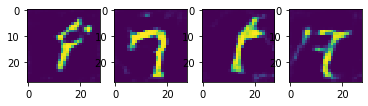

epoch:1800  d_loss:0.6293  g_loss:1.1538


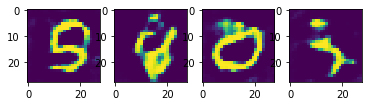

epoch:1900  d_loss:0.6213  g_loss:1.2714


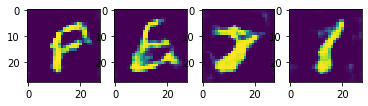

epoch:2000  d_loss:0.6242  g_loss:1.3373


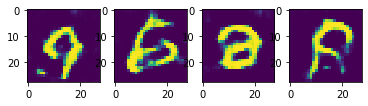

epoch:2100  d_loss:0.5971  g_loss:1.2031


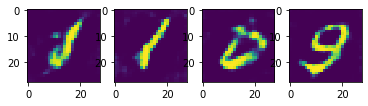

epoch:2200  d_loss:0.7207  g_loss:1.0556


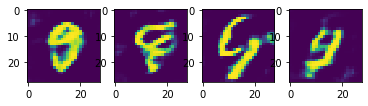

epoch:2300  d_loss:0.6154  g_loss:1.2746


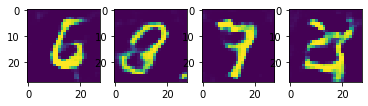

epoch:2400  d_loss:0.5916  g_loss:1.2729


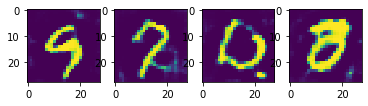

epoch:2500  d_loss:0.6462  g_loss:1.1721


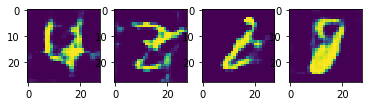

epoch:2600  d_loss:0.5853  g_loss:1.3618


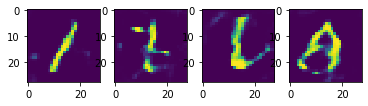

epoch:2700  d_loss:0.5941  g_loss:1.2117


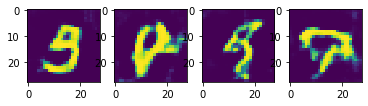

epoch:2800  d_loss:0.6220  g_loss:1.2044


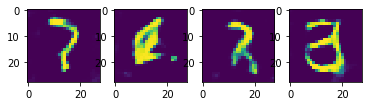

epoch:2900  d_loss:0.5828  g_loss:1.3303


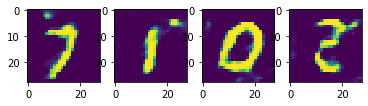

epoch:3000  d_loss:0.6162  g_loss:1.3776


In [10]:
epochs = 3001
batch_size = 64
gan_train(epochs,batch_size)

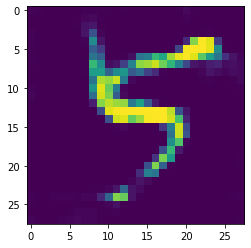

In [52]:
noise = np.random.normal(0,1,(batch_size,latent_dim))
im=generator.predict(noise)
plt.imshow(im[0, :, :, 0])

#### This person does not exist
* https://thispersondoesnotexist.com/